In [ ]:
import os 
from google.colab import drive 
drive.mount("/content/drive")
os.chdir("/content/drive/MyDrive/BME548_FinalProject")
!pwd

Mounted at /content/drive
/content/drive/MyDrive/BME548_FinalProject


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Apr 26 18:00:54 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 50:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


In [ ]:
import os
import cv2
import glob
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

### Preprocess Data

In [ ]:
def get_file_list (filePath):
    fileList = []
    for onefile in glob.glob(filePath):
        fileList.append(onefile)
    return fileList

def loadData (fileList):
    data = []
    cnt = 0
    # count = 1
    for onefile in fileList:
        data.append(cv2.imread(onefile, cv2.IMREAD_GRAYSCALE))
        # cnt += 1
        # if cnt >= 100:
        #   break
    return data

In [ ]:
datafileList = get_file_list("archive/frames/*.png")
labelfileList = []
for item in datafileList:
    labelfileList.append(item.replace('frames', 'masks'))

In [ ]:
frames = loadData(datafileList)

In [ ]:
masks = loadData(labelfileList)

In [ ]:
X = np.array(frames)
y = (np.stack(masks, axis=0) / 255.0).astype(int)

In [ ]:
all_indices = np.arange(0, X.shape[0])
np.random.shuffle(all_indices)
TEST_FRAC = 0.2 
test_indices  = all_indices[0:int(X.shape[0] * TEST_FRAC)]
train_indices = all_indices[int(X.shape[0] * TEST_FRAC):]
X_train = X[train_indices]
X_test  = X[test_indices]
y_train = y[train_indices]
y_test  = y[test_indices]
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(2184, 512, 512)
(2184, 512, 512)
(545, 512, 512)
(545, 512, 512)


### Prepare Baseline U-Net Model

In [ ]:
import tensorflow_probability as tfp
# import norm
from keras.constraints import max_norm
from keras import backend

# half_L1 = 512 * 512 //2
class L1Norm(tf.keras.constraints.Constraint):
    def __init__(self, desired=131072, min_value=131072, max_value=131072):
      self.min_value = min_value
      self.max_value = max_value
      self.desired = desired
      
    def __call__(self, w):
      w = backend.clip(w, 0, 1.5)
      norms = tf.reduce_sum(w, keepdims=True)

      if self.desired:
        desired = self.desired
      else:
        desired = backend.clip(norms, self.min_value, self.max_value)

      w = w * (desired / (backend.epsilon() + norms))
      w = backend.clip(w, 0.0001, 1-0.0001)
      return w


class L1Norm_Logits(tf.keras.constraints.Constraint):
    def __init__(self, desired=131072, min_value=131072, max_value=131072):
      self.min_value = min_value
      self.max_value = max_value
      self.desired = desired
    def __call__(self, w):
      probs = tf.sigmoid(10*w)
      norms = tf.reduce_sum(probs, keepdims=True)
      if self.desired:
        desired = self.desired
      else:
        desired = backend.clip(norms, self.min_value, self.max_value)
      probs = probs * (desired / (backend.epsilon() + norms))
      w = -tf.math.log(1/probs - 1)/10
      return w


# TEST CASE FOR LOGITS CONSTRAINTS

# weight_init = np.full((512, 512, 1), 0.1)
#         # weight_init = 0.8
# wTest = tf.Variable(initial_value=weight_init, trainable=True, constraint=L1Norm_Logits(), dtype='float32')
# wRes = L1Norm_Logits(131072, 131072).__call__(wTest)

# print('wRes', wRes)
# print('wTest: ', wTest)
# print('Sigmoid wRes: ', tf.sigmoid(10*wRes))


class quantization_layer(tf.keras.layers.Layer):
    def __init__(self, is_train=True):
        super(quantization_layer, self).__init__()
        self.trainable = is_train

    def build(self, input_shape):

        # Initialization for logits

        # weight_init = tf.zeros_initializer()
        # self.W = tf.Variable(initial_value=weight_init(shape=[input_shape[1], input_shape[2], 1]), trainable=True, constraint=L1Norm_Logits(), dtype='float32')

        # Initialization for probs

        weight_init = np.full((input_shape[1], input_shape[2], 1), 0.5)
        self.W = tf.Variable(initial_value=weight_init, trainable=True, constraint=L1Norm(), dtype='float32')



    def get_temp(self):
        temperature = 1.0

        # Set logits

        # dist = tfp.distributions.RelaxedBernoulli(temperature, logits=self.W*10)

        # Set probs

        dist = tfp.distributions.RelaxedBernoulli(temperature, probs=self.W)

        soft_choice = dist.sample()
        hard_choice = tf.round(soft_choice)
        choices = tf.stop_gradient(hard_choice - soft_choice) + soft_choice

        # print(choices)
        # for i in range(512):
        #   print(choices[i, :, 0])
        return choices
    
    def call(self, inputs):
        choices = self.get_temp()
        # outputs = tf.multiply(tf.math.floordiv(inputs, 128**choices), 128**choices)
        outputs = inputs//(choices*127+1) * (choices*127+1)

        return outputs

In [ ]:
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras import backend as K 
def dice_loss (y_true, y_pred) :
    y_true = tf.cast(y_true, tf.float32)
    smooth = 1 
    y_true_flat = K.flatten(y_true)
    y_pred_flat = K.flatten(y_pred)
    intersection = K.sum(y_pred_flat * y_true_flat)
    dice_coef = (2 * intersection + smooth) / (K.sum(y_true_flat) + K.sum(y_pred_flat) + smooth)
    return 1 - dice_coef

def segment_loss (y_true, y_pred) :
    # Segment Loss = Dice Loss + Binary Cross Entropy Loss
    seg_loss = dice_loss(y_true, y_pred) + binary_crossentropy(y_true, y_pred) 
    return seg_loss 

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
# model_checkpoint = "UNET_BASE.h5"
# model_checkpoint = "UNET_DICE_BCE.h5"
model_checkpoint = "quantize_probs.h5"
checkpoint_callback = ModelCheckpoint(filepath = model_checkpoint, 
                                      monitor = "val_loss",  
                                      save_best_only = True, 
                                      # save_weights_only = False, 
                                      save_weights_only = True, 
                                      mode = "min", 
                                      verbose = 1)

In [ ]:
from tensorflow.keras.callbacks import LearningRateScheduler
def scheduler (epoch, lr) :
    if epoch < 150 :
        return lr 
    else :
        return lr * tf.math.exp(-0.1)
lr_callback = LearningRateScheduler(schedule = scheduler, 
                                    verbose = 1)

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPool2D, Input, UpSampling2D
import tensorflow as tf
def create_unet(input_shape, num_classes):
    input_layer = Input(input_shape)
    x = input_layer
    x = quantization_layer()(x)
    # down path
    start_filters = 8
    skip_layers = []
    padding = "same"
    for i in range(3):
        x = Conv2D(start_filters * (2**i), 3, padding=padding, activation='relu')(x)
        x = Conv2D(start_filters * (2**i), 3, padding=padding, activation='relu')(x)
        skip_layers.append(x)
        x = MaxPool2D()(x)
    # bottleneck
    x = Conv2D(start_filters*(2**3),3, padding=padding, activation='relu')(x)
    x = Conv2D(start_filters*(2**3),3, padding='same', activation='relu')(x)
    # up path
    for i in range(3):
        x = UpSampling2D()(x)
        x = tf.concat([skip_layers[-(i+1)], x], axis=-1)
        x = Conv2D(start_filters*(2**(2-i)),3, padding='same', activation='relu')(x)
        x = Conv2D(start_filters*(2**(2-i)),3, padding='same', activation='relu')(x)
    # output = Conv2D(num_classes, 1, activation='softmax')(x)
    output = Conv2D(1, 1, activation="sigmoid")(x)
    model = tf.keras.Model(inputs=input_layer, outputs=output)
    return model

In [ ]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
model = create_unet([512, 512, 1], 2)
# model.compile(optimizer = Adam(learning_rate=0.0005), 
#               loss = SparseCategoricalCrossentropy())
model.compile(optimizer = Adam(learning_rate=0.001), 
              loss = segment_loss)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 quantization_layer (quantizati  (None, 512, 512, 1)  262144     ['input_1[0][0]']                
 on_layer)                                                                                        
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 8)  80          ['quantization_layer[0][0]']     
                                                                                              

In [ ]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras import models, layers
model.build(input_shape = [512, 512, 1])
layerout = [layer.output for layer in model.layers[0:3]]
actmodel = models.Model(inputs = model.input, outputs = layerout)
# acts = actmodel.predict(X_test[0:32])
# layer1out = acts[0]
# print(layer1out.shape)

In [ ]:
bad_predictions = model.predict(X_test)

check quantization output [  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.
  42.  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.
  56.  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.
  70.  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.
  84.  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.
  98.  99. 100. 101. 102. 103. 104. 105. 106. 107. 108. 109. 110. 111.
 112. 113. 114. 115. 116. 117. 118. 119. 120. 121. 122. 123. 124. 125.
 126. 127. 128. 129. 130. 131. 132. 133. 134. 135. 136. 137. 138. 139.
 140. 141. 142. 143. 144. 145. 146. 147. 148. 149. 150. 151. 152. 153.
 154. 155. 156. 157. 158. 159. 160. 161. 162. 163. 164. 165. 166. 167.
 168. 169. 170. 171. 172. 173. 174. 175. 176. 177. 178. 179. 180. 181.
 182. 183. 184. 185. 186. 187. 188. 189. 190. 191. 

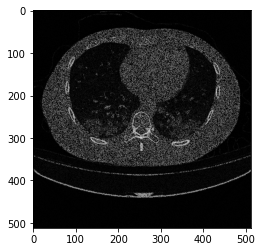

In [ ]:
get_quantization_output = K.function([model.layers[0].input],
                                  [model.layers[1].output])
predictions = get_quantization_output([X_test])[0]
plt.imshow(predictions[0,:,:, 0], cmap='gray')

# print('Check weights: ', (model.layers[1].weights)*127 + 1)
print('check quantization output', np.unique(predictions[0, :, :, 0]))

In [ ]:
model.layers[1].weights

[<tf.Variable 'quantization_layer/Variable:0' shape=(512, 512, 1) dtype=float32, numpy=
 array([[[0.5],
         [0.5],
         [0.5],
         ...,
         [0.5],
         [0.5],
         [0.5]],
 
        [[0.5],
         [0.5],
         [0.5],
         ...,
         [0.5],
         [0.5],
         [0.5]],
 
        [[0.5],
         [0.5],
         [0.5],
         ...,
         [0.5],
         [0.5],
         [0.5]],
 
        ...,
 
        [[0.5],
         [0.5],
         [0.5],
         ...,
         [0.5],
         [0.5],
         [0.5]],
 
        [[0.5],
         [0.5],
         [0.5],
         ...,
         [0.5],
         [0.5],
         [0.5]],
 
        [[0.5],
         [0.5],
         [0.5],
         ...,
         [0.5],
         [0.5],
         [0.5]]], dtype=float32)>]

In [ ]:
##########################################################################################

### Train Baseline U-Net Model
#### Note: The U-Net model has been trained and saved

In [ ]:
history = model.fit(x = X_train, y = y_train, 
                    epochs = 200, 
                    validation_data = (X_test, y_test), 
                    callbacks = [lr_callback, checkpoint_callback])
# history = model.fit(x = X_train, y = y_train, 
#                     epochs = 400,
#                     validation_data = (X_test, y_test))

In [ ]:
##########################################################################################

In [ ]:
model = create_unet([512, 512, 1], 2)
model.load_weights("quantize_probs.h5")

In [ ]:
get_quantization_output = K.function([model.layers[0].input],
                                  [model.layers[1].output])
predictions = get_quantization_output([X_test])[0]
plt.imshow(predictions[0,:,:, 0], cmap='gray')

# model.layers[1].weights
print('check quantization output', np.unique(predictions[0, :, :, 0]))


In [ ]:
# model.layers[1].weights
print(model.layers[1].weights[0])
print(np.min(model.layers[1].weights[0]))
print(np.max(model.layers[1].weights[0]))
# print(model.layers[1].weights)
# print(len(model.layers[1].weights))
# print(len(model.layers[1].weights[:]))
# print('check 0: ', sum(sum(model.layers[1].weights)))
# print(model.layers[1].weights[:][1][0])

<tf.Variable 'quantization_layer_8/Variable:0' shape=(512, 512, 1) dtype=float32, numpy=
array([[[5.0593829e-01],
        [9.2969370e-01],
        [6.1428958e-01],
        ...,
        [8.3084285e-01],
        [7.6132303e-01],
        [8.1502461e-01]],

       [[9.4609863e-01],
        [8.7916529e-01],
        [9.9751055e-01],
        ...,
        [8.8292408e-01],
        [9.6072108e-01],
        [9.5991683e-01]],

       [[9.6403849e-01],
        [9.9988073e-01],
        [9.9989998e-01],
        ...,
        [9.0431839e-01],
        [9.0350360e-01],
        [9.1520238e-01]],

       ...,

       [[6.1167783e-01],
        [6.5376997e-01],
        [6.5716833e-01],
        ...,
        [7.3250467e-01],
        [7.5018919e-01],
        [7.3293090e-01]],

       [[2.5565094e-01],
        [2.1792218e-02],
        [2.5694668e-01],
        ...,
        [8.4215045e-01],
        [8.0908096e-01],
        [6.1758584e-01]],

       [[4.1211832e-01],
        [3.1682667e-01],
        [1.1704887e-04]

(512, 512)


array([9.99999975e-05, 1.00018318e-04, 1.00018886e-04, ...,
       9.99899328e-01, 9.99899745e-01, 9.99899983e-01], dtype=float32)

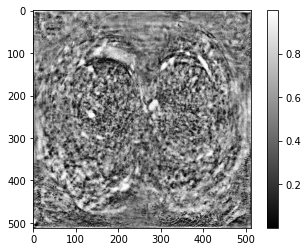

In [ ]:
checkIm = np.array(model.layers[1].weights[0]).reshape((512, 512))
print(checkIm.shape)

# for i in range(512):
#   for j in range(512):
#     if checkIm[i,j]>=0.7:
#       checkIm[i,j] = 1
#     else:
#       checkIm[i,j] = 0


im = plt.imshow(checkIm, cmap='gray')
plt.colorbar(im);
np.unique(checkIm)

### Evaluate Trained U-Net Model

In [ ]:
from tensorflow.keras.models import load_model 
# unet_model = load_model("UNET_BASE.h5")
unet_model = load_model("UNET_DICE_BCE.h5", compile = False)

In [ ]:
good_predictions = unet_model.predict(X_test)

In [ ]:
# def interpret_results (preds) :
#     out = np.zeros((preds.shape[0], 512, 512))
#     for i in range(preds.shape[0]) :
#         for j in range(512) :
#             for k in range(512) :
#                 if preds[i,j,k,1] > preds[i,j,k,0] :
#                     out[i,j,k] = 1
#     return out  

In [ ]:
def interpret_results (preds, active = "softmax") :
    out = np.zeros((preds.shape[0], 512, 512))
    if active == "softmax" :
        out[preds[:,:,:,1] > preds[:,:,:,0]] = 1
    if active == "sigmoid" :
        out[preds[:,:,:,0] > 0.5] = 1
    return out 

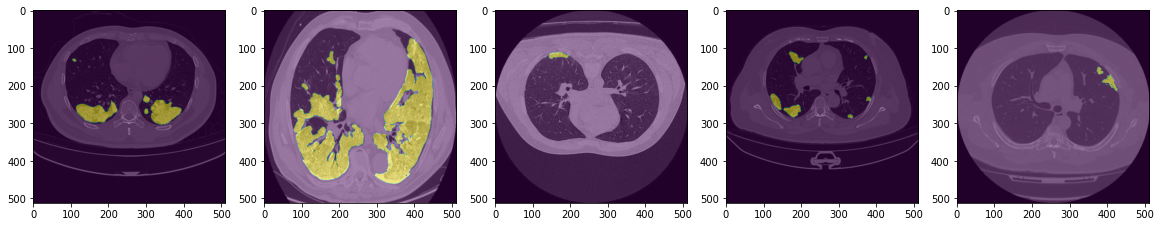

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(20, 10))
for i in range(5) :
    axs[i].imshow(X_test[i], cmap=plt.cm.gray)
    axs[i].imshow(y_test[i], alpha=0.5)

In [ ]:
bad_pred = bad_predictions[0] 
good_pred = good_predictions[0]

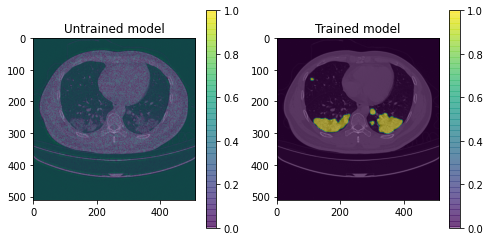

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
axs[0].set_title("Untrained model")
axs[0].imshow(X_test[0], cmap=plt.cm.gray)
im = axs[0].imshow(bad_pred[:,:,0], alpha=0.5, vmin=0, vmax=1)
plt.colorbar(im, ax=axs[0])

axs[1].set_title("Trained model")
axs[1].imshow(X_test[0], cmap=plt.cm.gray)
im = axs[1].imshow(good_pred[:,:,0], alpha=0.5, vmin=0, vmax=1)
plt.colorbar(im, ax=axs[1]);

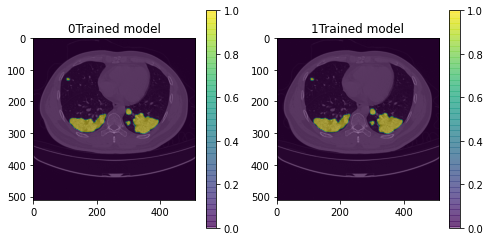

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
axs[0].set_title("0Trained model")
axs[0].imshow(X_test[0], cmap=plt.cm.gray)
im = axs[0].imshow(good_pred[:,:,0], alpha=0.5, vmin=0, vmax=1)
plt.colorbar(im, ax=axs[0])

axs[1].set_title("1Trained model")
axs[1].imshow(X_test[0], cmap=plt.cm.gray)
im = axs[1].imshow(good_pred[:,:,0], alpha=0.5, vmin=0, vmax=1)
plt.colorbar(im, ax=axs[1]);

In [ ]:
y_test_pred = interpret_results(good_predictions, active="sigmoid")

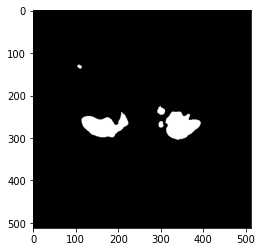

In [ ]:
plt.imshow(y_test[0], cmap = "gray");

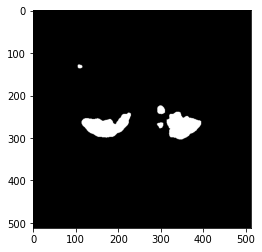

In [ ]:
plt.imshow(y_test_pred[0], cmap = "gray");